In [64]:
# import libraries

import os
import re
import pandas as pd
import numpy as np
import matplotlib
import statsmodels.api as sm
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from collections import Counter
from collections import defaultdict
from collections import deque


In [65]:
# Set some options
np.set_printoptions(precision=3)
np.seterr(divide='ignore',invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [66]:
# define data and util functions

def marital_status_to_num(val):
    if val == 'M':
        return 0
    elif val == 'S':
        return 1
    elif val == 'D':
        return 2
    elif val == 'W':
        return 3
    else:
        return np.nan

def marital_status_to_str(val):
    if val == 0:
        return 'married'
    elif val == 1:
        return 'single'
    elif val == 2:
        return 'divorced'
    elif val == 3:
        return 'widowed'
    else:
        return np.nan

data_dict = {
    'data': {
        'rename': {
            'ID Number': 'id',
            'Lifetime HC': 'cum_donation',
            'Email Present': 'has_email',
            'BusPhone Present': 'has_business_phone',
            'Grad Year': 'grad_year',
            'Marital Status': 'marital_status',
            'SpouseID Present': 'has_spousal_record',
            'JobTitle Present': 'has_job_title',
            'VarsityAth Present': 'has_activity_athlete',
            'StudGovt Present': 'has_activity_government',
            'OtherStudActs Present': 'has_activity_other',
            'Greek Present': 'has_activity_greek',
            'Prefix is Mr.': 'is_mr',
            'Prefix is Ms.': 'is_ms',
            'Prefix is Dr.': 'is_dr',
            'Prefix is Mrs.': 'is_mrs'
        },
        'dtype': {
            'ID Number': str,
            'Lifetime HC': float,
            'Grad Year': int,
            'Marital Status': str
        }
    },
    'dummy': {
        'list': [
            'cum_range',
            'grad_decade',
            'imp_marital_status',
        ],
        'prefix': {
            'cum_range': 'bin_cum_range',
            'grad_decade': 'bin_grad_decade',
            'imp_marital_status': 'bin_imp_marital_status'
        },
        'giving': {
            'bins': [
                0.00,
                1.00,
                1000.00,
                10000.00,
                25000.00,
                50000.00,
                100000.00,
                250000.00,
                500000.00,
                1000000.00,
                2500000.00,
                5000000.00,
                10000000.00,
                15000000.00
            ],
            'labels': [
                '$0',
                '$1-$999.99',
                '$1K-$9.99K',
                '$10K-$24.99K',
                '$25K-$49.99K',
                '$50K-$99.99K',
                '$100K-$249.99K',
                '$250K-$499.99K',
                '$500K-$999.99K',
                '$1M-$2.49M',
                '$2.5M-$4.99M',
                '$5M-$9.99M',
                '$10M-$14.99M'
            ]
        },
        'grad': {
            'bins': [
                1900,
                1910,
                1920,
                1930,
                1940,
                1950,
                1960,
                1970,
                1980,
                1990,
                2000,
                2010,
                2020
            ],
            'labels': [
                '1900s',
                '1910s',
                '1920s',
                '1930s',
                '1940s',
                '1950s',
                '1960s',
                '1970s',
                '1980s',
                '1990s',
                '2000s',
                '2010s'
            ]
        }
    },
    'cols': {
        'bools': [
            'has_email',
            'has_business_phone',
            'has_spousal_record',
            'has_job_title',
            'has_activity_athlete',
            'has_activity_government',
            'has_activity_other',
            'has_activity_greek',
            'is_mr',
            'is_ms',
            'is_dr',
            'is_mrs',
            'has_donated'
        ],
        'bin_grad': [
            'bin_grad_decade_1900s',
            'bin_grad_decade_1910s',
            'bin_grad_decade_1920s',
            'bin_grad_decade_1930s',
            'bin_grad_decade_1940s',
            'bin_grad_decade_1950s',
            'bin_grad_decade_1960s',
            'bin_grad_decade_1970s',
            'bin_grad_decade_1980s',
            'bin_grad_decade_1990s',
            'bin_grad_decade_2000s',
            'bin_grad_decade_2010s'
        ],
        'bin_giving': [
            'bin_cum_range_$0',
            'bin_cum_range_$1-$999.99',
            'bin_cum_range_$1K-$9.99K',
            'bin_cum_range_$10K-$24.99K',
            'bin_cum_range_$25K-$49.99K',
            'bin_cum_range_$50K-$99.99K',
            'bin_cum_range_$100K-$249.99K',
            'bin_cum_range_$250K-$499.99K',
            'bin_cum_range_$500K-$999.99K',
            'bin_cum_range_$1M-$2.49M',
            'bin_cum_range_$2.5M-$4.99M',
            'bin_cum_range_$5M-$9.99M',
            'bin_cum_range_$10M-$14.99M'
        ],
        'bin_marital': [
            'bin_imp_marital_status_divorced',
            'bin_imp_marital_status_married',
            'bin_imp_marital_status_single',
            'bin_imp_marital_status_widowed'
        ],
        'log': [
            'has_donated'
        ],
        'lin': [
            'cum_donation'
        ],
        'all_cols': [
            'has_email',
            'has_business_phone',
            'has_spousal_record',
            'has_job_title',
            'has_activity_athlete',
            'has_activity_government',
            'has_activity_other',
            'has_activity_greek',
            'is_mr',
            'is_ms',
            'is_dr',
            'is_mrs',
            'has_donated',
            'grad_year',
            'cum_donation',
            'bin_grad_decade_1900s',
            'bin_grad_decade_1910s',
            'bin_grad_decade_1920s',
            'bin_grad_decade_1930s',
            'bin_grad_decade_1940s',
            'bin_grad_decade_1950s',
            'bin_grad_decade_1960s',
            'bin_grad_decade_1970s',
            'bin_grad_decade_1980s',
            'bin_grad_decade_1990s',
            'bin_grad_decade_2000s',
            'bin_grad_decade_2010s',
            'bin_cum_range_$0',
            'bin_cum_range_$1-$999.99',
            'bin_cum_range_$1K-$9.99K',
            'bin_cum_range_$10K-$24.99K',
            'bin_cum_range_$25K-$49.99K',
            'bin_cum_range_$50K-$99.99K',
            'bin_cum_range_$100K-$249.99K',
            'bin_cum_range_$250K-$499.99K',
            'bin_cum_range_$500K-$999.99K',
            'bin_cum_range_$1M-$2.49M',
            'bin_cum_range_$2.5M-$4.99M',
            'bin_cum_range_$5M-$9.99M',
            'bin_cum_range_$10M-$14.99M',
            'bin_imp_marital_status_divorced',
            'bin_imp_marital_status_married',
            'bin_imp_marital_status_single',
            'bin_imp_marital_status_widowed'
        ]
    }
}

In [67]:
project_dir = os.path.join(os.path.abspath(''),os.pardir)
data_dir = os.path.join(project_dir,'data')
data_raw_dir = os.path.join(data_dir,'raw')

file_list = []

for file in os.scandir(data_raw_dir):
    file_list.append(os.path.join(data_raw_dir,file.name))

df = pd.read_excel(io=file_list[0],
                   sheet_name='Sheet1',
                   dtype=data_dict['data']['dtype'])
df = df.rename(columns=data_dict['data']['rename'])
dre_df = df

/home/rob/.local/share/virtualenvs/assignment2-vA0J_QZc/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [68]:
# drop irrelevant columns
df = df.drop(columns='id')

In [69]:
# create a logistic column version of cum_donation_value called has_donated as an additional target variable
df['has_donated'] = np.where(df['cum_donation']>0.0,1,0)

y_log = df[['has_donated']]
y_lin = df[['cum_donation']]

In [70]:
# imputing
df['marital_status'] = df['marital_status'].apply(marital_status_to_num)
df.loc[df['marital_status'].isnull(),'m_marital_status'] = 1
df.loc[df['marital_status'].notnull(),'m_marital_status'] = 0

df_marital_status = df[['m_marital_status']]
df = df.drop(columns='m_marital_status')

imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df),columns=df.columns)
df = df.rename(columns={'marital_status': 'imp_marital_status'})
df = pd.concat((df,df_marital_status),axis=1)

df['imp_marital_status'] = df['imp_marital_status'].round().astype(int)
df['imp_marital_status'] = df['imp_marital_status'].apply(marital_status_to_str)
df[data_dict['cols']['bools']] = df[data_dict['cols']['bools']].astype(int)

In [71]:
# binning
df.sort_values('cum_donation',inplace=True)
df['cum_range'] = \
    pd.cut(x=df['cum_donation'],
           bins=data_dict['dummy']['giving']['bins'],
           labels=data_dict['dummy']['giving']['labels'],
           right=False)
df.sort_values('grad_year',inplace=True)
df['grad_decade'] = pd.cut(x=df['grad_year'],
                           bins=data_dict['dummy']['grad']['bins'],
                           labels=data_dict['dummy']['grad']['labels'],
                           right=False)
df.sort_index(inplace=True)

In [72]:
# dummying
dummy_filter = df[data_dict['dummy']['list']]
dummy_df = pd.get_dummies(data=dummy_filter,
                          prefix=data_dict['dummy']['prefix'],
                          columns=data_dict['dummy']['list'])
df = pd.concat(([df,dummy_df]),axis=1)

# all possible lin/log features
X = df.drop(columns=['imp_marital_status','cum_range','grad_decade'])

In [73]:
# Different models will be denoted through an encoded sting of
# bits from right to left. As more variety is introduced this
# bitwise representation will grow in length.

# 0th bit [-1]:         0 - logistic regression
#                       1 - linear regression
# 1st bit [-2]:         0 - grad_year int
#                       1 - grad_year binned
# 2nd bit [-3]:         0 - cum_donation float
#                       1 - cum_donation binned
# 3rd-5th bit [-6:-3]:  000 - no automatic feature selection
#                       001 - chi square filtering (chi)
#                       010 - Random Forest Importance (rfi)
#                       011 - Recursive Feature Elimination Cross Validation (rfe)
#                       100 - Forward Feature Elimination (ffe)
# 6th-7th bit [-8:-6]:  00 - unscaled
#                       01 - MinMaxScaler
#                       10 - StandardScaler
#                       11 - RobustScaler
# 8th bit [-9]:         0 - Cross Fold Validation
#                       1 - Stacking

# 0th bit: is linear regression

dict_3bit = dict()

for i in [1,0]:
    model_bit = deque()
    if i == 1:
        model_bit.appendleft('1')
        y = y_lin
        X = sm.add_constant(X)
        feature_list_lv0 = list((Counter(X.columns.tolist())
                                 -Counter(data_dict['cols']['lin']))
                                .elements())

    else:
        model_bit.appendleft('0')
        y = y_log
        X = X
        feature_list_lv0 = list((Counter(X.columns.tolist())
                                 -Counter(data_dict['cols']['log']))
                                .elements())


    # 1st bit: is grad_year binned
    for j in [1,0]:
        if j == 1:
            model_bit.appendleft('1')
            feature_list_lv1 = list((Counter(feature_list_lv0)
                                     -Counter(['grad_year']))
                                    .elements())
        else:
            model_bit.appendleft('0')
            feature_list_lv1 = list((Counter(feature_list_lv0)
                                     -Counter(data_dict['cols']['bin_grad']))
                                    .elements())

        # 2nd bit: is cum_donation binned
        for k in [1,0]:
            feature_list_lv2 = feature_list_lv1
            if k == 1:
                model_bit.appendleft('1')
                feature_list_lv2 = list((Counter(feature_list_lv1)
                                         -Counter(['cum_donation']))
                                        .elements())
            else:
                model_bit.appendleft('0')
                feature_list_lv2 = list((Counter(feature_list_lv1)
                     -Counter(data_dict['cols']['bin_giving']))
                    .elements())
            bit_str = ''.join(model_bit)

            # filter linear regressions where linear target would be
            # present
            if not re.match('1\d1',bit_str):
                model_dict = {
                    bit_str: {
                        'y': y,
                        'X': X[feature_list_lv2]
                    }
                }
                dict_3bit.update(model_dict)
            model_bit.popleft()
        model_bit.popleft()
    model_bit.popleft()

In [74]:
def get_chi(bit_str:str, d):
    test = SelectKBest(score_func=chi2,k='all')

    label = d['y']
    features = d['X']

    feature_list = list(features.columns)
    chi_scores = test.fit(features,label)
    chi_list = list(zip(feature_list,chi_scores.scores_))
    chi_df = pd.DataFrame(chi_list,columns=['feature','chi'])
    chi_df = chi_df[chi_df['chi']>3.8]

    filtered_features = chi_df['feature'].tolist()
    d.update({'X':d['X'][filtered_features]})
    d.update({'afs':chi_df})

    return d

In [75]:
def get_rfi(bit_str:str, d):
    label = d['y']
    features = d['X']

    feature_list = list(features.columns)
    np_features = np.array(features)

    if bit_str[-1] == '0':
        rf = RandomForestClassifier(n_estimators=1000)
    else:
        rf = RandomForestRegressor(n_estimators=1000)

    rf.fit(np_features,label.values.ravel())
    importances = list(rf.feature_importances_)
    feature_importances = list(zip(feature_list,importances))
    rfi_df = pd.DataFrame(feature_importances,columns=['feature','rfi'])
    rfi_df = rfi_df.sort_values(by='rfi',ascending=False)

    # filter out features that do not exceed the average importance value
    importance_filter = (rfi_df['rfi'].sum())/(rfi_df['rfi'].count())
    rfi_df = rfi_df[rfi_df['rfi']>importance_filter]

    filtered_features = rfi_df['feature'].tolist()
    d.update({'X':d['X'][filtered_features]})
    d.update({'afs': rfi_df})

    return d

In [76]:
def get_rfecv(bit_str, d):
    label = d['y']
    features = d['X']

    feature_list = list(features.columns)

    if bit_str[-1] == '0':
        estimator = LogisticRegression(max_iter=500)
    else:
        estimator = LinearRegression()
    selector = RFECV(estimator=estimator)
    selector.fit(features,label.values.ravel())
    ranking = list(selector.support_)
    feature_ranking = list(zip(feature_list,ranking))
    rfecv_df = pd.DataFrame(feature_ranking,columns=['feature','rfe'])

    # filter out features rfe considers insignificant
    rfecv_df = rfecv_df[rfecv_df['rfe']==True]

    filtered_features = rfecv_df['feature'].tolist()
    d.update({'X':d['X'][filtered_features]})
    d.update({'afs': rfecv_df})
    return d

In [77]:
def get_ffe(bit_str:str, d):
    label = d['y']
    features = d['X']
    feature_list = list(features.columns)
    ffe = f_regression(features,label.values.ravel())
    ffe_list = []
    for i in range(0,len(feature_list)):
        ffe_list.append({'feature':feature_list[i],
                                'ffe':ffe[0][i]})
    ffe_df = pd.DataFrame(ffe_list)

    ffe_filter = (ffe_df['ffe'].sum()/ffe_df['ffe'].count())
    ffe_df = ffe_df[ffe_df['ffe']>ffe_filter]

    filtered_features = ffe_df['feature'].tolist()
    d.update({'X':d['X'][filtered_features]})
    d.update({'afs':ffe_df})
    return d

dict_6bit = dict()

In [78]:
# 3th-5th bit: Automatic Feature Selection (afs)
# 000 - no automatic feature selection
# 001 - chi square filtering (chi)
# 010 - Random Forest Importance (rfi)
# 011 - Recursive Feature Elimination Cross Validation (rfe)
# 100 - Forward Feature Elimination (ffe)

for k_model, v_data in dict_3bit.items():
    for auto in [('000', None), ('001', get_chi), ('010', get_rfi),
                 ('011', get_rfecv), ('100', get_ffe)]:
        model_bit = deque(k_model)
        data = v_data.copy()

        # skips no automatic feature selection
        if auto[0] == '000':
            model_bit.appendleft(auto[0])
        # skips chi-squaring linear regressions
        elif (auto[1] is get_chi) and (bit_str[-1] == '1'):
            model_bit.appendleft('000')
        else:
            model_bit.appendleft(auto[0])
            data = auto[1](model_bit,data)
        bit_str = ''.join(model_bit)
        dict_6bit.update({bit_str: data})

In [85]:
ff_dict = dict()
all_cols = data_dict['cols']['all_cols']

for k,v in dict_6bit.items():
    if k[-6:-3] != '000':
        for ki,vi in v.items():
            if ki == 'X':
                data = dict()
                st = set(vi)
                for i in all_cols:
                    if i in st:
                        data.update({i:1})
                    else:
                        data.update({i:0})
                ff_dict.update({k:data})

ff_df = pd.DataFrame(ff_dict)

010011     8
011011     8
100011     4
010001     7
011001     3
100001     4
001110    32
010110     3
011110     1
100110     1
001010    25
010010     1
011010     1
100010     8
001100    25
010100     3
011100     1
100100     1
001000    18
010000     2
011000     1
100000     6
dtype: int64

In [563]:
# 6th-7th bit: Scaling
# 00 - unscaled
# 01 - MinMaxScaler
# 10 - StandardScaler
# 11 - RobustScaler

dict_8bit = defaultdict()

for k_model, v_data in dict_6bit.items():
    for scale in [('00',None),('01',MinMaxScaler()),('10',StandardScaler()),
                  ('11',RobustScaler())]:
        X_scaler = scale[1]
        y_scaler = scale[1]
        model_bit = deque(k_model)
        data = v_data.copy()

        y_scale = data['y']
        y_scale_labels = list(y_scale.columns)
        X_scale = data['X']
        X_scale_labels = list(X_scale.columns)

        data.update({'y_scale': y_scale,
                     'y_scale_labels': y_scale_labels,
                     'X_scale': X_scale,
                     'X_scale_labels': X_scale_labels,
                     'X_scaler': None,
                     'y_scaler': None})

        if scale[0] == '00':
            model_bit.appendleft(scale[0])

        else:
            if model_bit[-1] == '1':
                y_scale = y_scaler.fit_transform(np.array(y_scale)
                                                  .reshape(-1,1))
                data.update({'y_scale': y_scale,
                             'y_scaler': y_scaler})

            model_bit.appendleft(scale[0])
            X_scale = X_scaler.fit_transform(X_scale)
            data.update({'X_scale': X_scale,
                         'X_scaler': X_scaler})
        bit_str = ''.join(model_bit)
        dict_8bit.update({bit_str: data})

In [564]:
print(len(dict_8bit))

for k,v in dict_8bit.items():
    print(k)
    for ki,vi in v.items():
        print('\t',ki,'\t',np.shape(vi))

112
00000011
	 y 	 (5000, 1)
	 X 	 (5000, 31)
	 y_scale 	 (5000, 1)
	 y_scale_labels 	 (1,)
	 X_scale 	 (5000, 31)
	 X_scale_labels 	 (31,)
01000011
	 y 	 (5000, 1)
	 X 	 (5000, 31)
	 y_scale 	 (5000, 1)
	 y_scale_labels 	 (1,)
	 X_scale 	 (5000, 31)
	 X_scale_labels 	 (31,)
10000011
	 y 	 (5000, 1)
	 X 	 (5000, 31)
	 y_scale 	 (5000, 1)
	 y_scale_labels 	 (1,)
	 X_scale 	 (5000, 31)
	 X_scale_labels 	 (31,)
11000011
	 y 	 (5000, 1)
	 X 	 (5000, 31)
	 y_scale 	 (5000, 1)
	 y_scale_labels 	 (1,)
	 X_scale 	 (5000, 31)
	 X_scale_labels 	 (31,)
00010011
	 y 	 (5000, 1)
	 X 	 (5000, 9)
	 afs 	 (9, 2)
	 y_scale 	 (5000, 1)
	 y_scale_labels 	 (1,)
	 X_scale 	 (5000, 9)
	 X_scale_labels 	 (9,)
01010011
	 y 	 (5000, 1)
	 X 	 (5000, 9)
	 afs 	 (9, 2)
	 y_scale 	 (5000, 1)
	 y_scale_labels 	 (1,)
	 X_scale 	 (5000, 9)
	 X_scale_labels 	 (9,)
10010011
	 y 	 (5000, 1)
	 X 	 (5000, 9)
	 afs 	 (9, 2)
	 y_scale 	 (5000, 1)
	 y_scale_labels 	 (1,)
	 X_scale 	 (5000, 9)
	 X_scale_labels 	 (9,)
11010011

In [565]:
# 9th bit: Modeling
# also rescaling
# 1 - Stacking
# 0 - Cross-fold validation

def get_unfit_regressors():
    models = list()
    models.append(ElasticNet())
    models.append(SVR(gamma='scale'))
    models.append(DecisionTreeRegressor())
    models.append(AdaBoostRegressor())
    models.append(RandomForestRegressor(n_estimators=10))
    models.append(ExtraTreesRegressor(n_estimators=10))
    return models

def get_unfit_classifiers():
    models = list()
    models.append(LogisticRegression())
    models.append(DecisionTreeClassifier())
    models.append(AdaBoostClassifier())
    models.append(RandomForestClassifier(n_estimators=10))
    return models

def evaluate_model_regressor(y_test, predictions, model):
    mse = mean_squared_error(y_test, predictions)
    rmse = round(np.sqrt(mse),3)
    print(" RMSE:" + str(rmse) + " " + model.__class__.__name__)

def evaluate_model_classifier(y_test, predictions, model):
    precision = round(metrics.precision_score(y_test, predictions),2)
    recall = round(metrics.recall_score(y_test, predictions), 2)
    f1 = round(metrics.f1_score(y_test, predictions), 2)
    accuracy = round(metrics.accuracy_score(y_test, predictions), 2)

def fit_base_models(X_train, y_train, X_test, models,y_scaler):
    dfPredictions = pd.DataFrame()
    # Fit base model and store its predictions in dataframe.
    for i in range(0, len(models)):
        models[i].fit(X_train, y_train)
        predictions = models[i].predict(X_test)
        if y_scaler:
            predictions = y_scaler.inverse_transform(np.array(predictions).reshape(-1,1))
        colName = str(i)
        # Add base model predictions to column of data frame.
        dfPredictions[colName] = predictions
    return dfPredictions, models

def fit_stacked_model_regressor(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

def fit_stacked_model_classifier(X, y):
    model = LogisticRegression()
    model.fit(X, y)
    return model

def get_cross_fold_log(X,y,X_scaler,y_scaler,selection_name,selection,X_label,
                       y_label,k_fold):
    accuracy_list = list()
    precision_list = list()
    recall_list = list()
    f1_list = list()
    coef_list = list()

    for train_index, test_index in k_fold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        lm = LogisticRegression(fit_intercept=True,
                                solver='liblinear')
        lm.fit(X_train, np.ravel(y_train))

        y_pred = lm.predict(X_test)
        if y_scaler:
            y_pred = y_scaler.inverse_transform(np.array(y_pred).reshape(-1,1))

        accuracy = metrics.accuracy_score(y_test,y_pred)
        precision = metrics.precision_score(y_test,y_pred,zero_division=0)
        recall = metrics.recall_score(y_test,y_pred,zero_division=0)
        f1 = metrics.f1_score(y_test,y_pred,zero_division=0)

        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        coef_list.append(pd.DataFrame({"feature":X_label,"coef":lm.coef_[0]}))

    return {
        'accuracy_avg' : np.mean(accuracy_list),
        'accuracy_sd' : np.std(accuracy_list),
        'precision_avg' : np.mean(precision_list),
        'precision_sd' : np.std(precision_list),
        'recall_avg' : np.mean(recall_list),
        'recall_sd' : np.std(recall_list),
        'f1_avg' : np.mean(f1_list),
        'f1_sd' : np.std(f1_list),
        'coef' : pd.concat(coef_list).groupby('feature',as_index=False,sort=False)['coef'].mean()
    }

def get_cross_fold_lin(X,y,X_scaler,y_scaler,selection_name,selection,X_label,
                       y_label,k_fold):
    rmseList = list()
    bicList = list()
    rsquareLst = list()
    coef_list = list()

    for train_index, test_index in k_fold.split(X):
        X_train = X.loc[X.index.isin(train_index)]
        X_test  = X.loc[X.index.isin(test_index)]
        y_train = y.loc[y.index.isin(train_index)]
        y_test  = y.loc[y.index.isin(test_index)]

        # Perform linear regression.
        model = sm.OLS(y_train, X_train).fit()
        y_pred = model.predict(X_test)
        if y_scaler:
            y_pred = y_scaler.inverse_transform(np.array(y_pred).reshape(-1,1))

        mse    = metrics.mean_squared_error(y_test, y_pred)
        rmse   = np.sqrt(mse)
        bic    = model.bic
        rsqr   = model.rsquared

        rmseList.append(rmse)
        bicList.append(bic)
        rsquareLst.append(rsqr)
        coef_list.append(pd.DataFrame({'feature':X_label,'coef':model.params}))

    return {
        'rmse_avg': np.mean(rmseList),
        'rmse_sd': np.std(rmseList),
        'bic_avg': np.mean(bicList),
        'bic_sd': np.std(bicList),
        'rsquare_avg': np.mean(rsquareLst),
        'rsquare_sd': np.std(rsquareLst),
        'coef': pd.concat(coef_list).groupby('feature',as_index=False,sort=False)['coef'].mean()
    }

dict_9bit = defaultdict()

for k_model, v_data in dict_8bit.items():
    for model in ['0','1']:
        model_bit = deque(k_model)
        data = v_data.copy()

        # unwrap the dict
        X = data['X_scale']
        y = data['y_scale']
        X_scaler = data['X_scaler']
        y_scaler = data['y_scaler']

        for i in [('000', None), ('001', 'chi'), ('010', 'rfi'),
                 ('011', 'rfecv'), ('100', 'ffe')]:
            if bit_str[-6:-3] == i[0]:
                selection_name = i[1]
                selection = data['afs']
        X_label = data['X_scale_labels']
        y_label = data['y_scale_labels']

        if model == '0':
            model_bit.appendleft('0')
            k_fold = KFold(n_splits=3,shuffle=True)
            if model_bit[-1] == '0':
                result = get_cross_fold_log(X,y,X_scaler,y_scaler,selection_name,selection,X_label,y_label,k_fold)
            else:
                result = get_cross_fold_lin(X,y,X_scaler,y_scaler,selection_name,selection,X_label,y_label,k_fold)
        else:
            model_bit.appendleft('1')
            X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.70)
            X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.50)

            if model_bit[-1] == '0':
                unfit_models = get_unfit_classifiers()
            else:
                unfit_models = get_unfit_regressors()

            pred_df, models = fit_base_models(X_train,y_train,X_test,unfit_models,y_scaler)

            if model_bit[-1] == '0':
                stacked_model = fit_stacked_model_classifier(pred_df,y_test)
            else:
                stacked_model = fit_stacked_model_regressor(pred_df,y_test)



# Assignment 2

## Introduction
The purpose of this project is to identify the most fit classification and regression models for determining the likelihood of an alumni to donate an institution and in what amounts.

### The Dataset
The dataset used in this assignment is provided by Kevin MacDonell and is available at <a href="https://cooldata.wordpress.com/cooldatabook/">CoolData blog</a>. It accompanies a freely published book **COOL DATA: A how-to guide for predictive modeling for higher education advancement and nonprofits using multiple linear regression in Data Desk** (Current version: 1.1.0, 2018-01-13).

### The Client
The client is the hypothetical owner of this dataset - a post-secondary charitable foundation and/or alumni office.

## Data Exploration
On import - and after some minor tweaking of column names - the data appears as follows:

In [98]:
dre_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       5000 non-null   object  
 1   cum_donation             5000 non-null   float64 
 2   has_email                5000 non-null   int64   
 3   has_business_phone       5000 non-null   int64   
 4   grad_year                5000 non-null   int64   
 5   marital_status           4965 non-null   object  
 6   has_spousal_record       5000 non-null   int64   
 7   has_job_title            5000 non-null   int64   
 8   has_activity_athlete     5000 non-null   int64   
 9   has_activity_government  5000 non-null   int64   
 10  has_activity_other       5000 non-null   int64   
 11  has_activity_greek       5000 non-null   int64   
 12  is_mr                    5000 non-null   int64   
 13  is_ms                    5000 non-null   int64   
 14  is_dr   

Notable here is the largest amount of columns that indicate boolean descriptions of the alumni in question. From this, it can be confidently concluded that this dataset has already been significantly cleaned and transformed from its original state to one that is more amenable to statistical analysis.

Additional features of interest include the <code>marital_status</code> column, which is the only instance of nulls in this dataset that will require imputing. Furthermore, the <code>cum_donation</code> column contains <code>float64</code> data indicating the total amount the constituent has donated to the client's organization. Lastly, the <code>grad_year</code> column contains information about when the alumni graduated. <code>id</code> will be dropped as it does not have any statistical significance.

### Boolean Features

In [99]:
# Exploring all the boolean columns
dre_bool = dre_df[['has_email',
                  'has_business_phone',
                  'has_spousal_record',
                  'has_job_title',
                  'has_activity_athlete',
                  'has_activity_government',
                  'has_activity_other',
                  'has_activity_greek',
                  'is_mr',
                  'is_ms',
                  'is_dr',
                  'is_mrs']]
dre_bool_report = dre_bool.apply(pd.value_counts)
print(dre_bool_report.sum())
dre_bool_report.T

has_email                  5000
has_business_phone         5000
has_spousal_record         5000
has_job_title              5000
has_activity_athlete       5000
has_activity_government    5000
has_activity_other         5000
has_activity_greek         5000
is_mr                      5000
is_ms                      5000
is_dr                      5000
is_mrs                     5000
dtype: int64


,0,1
has_email,2125,2875
has_business_phone,3171,1829
has_spousal_record,4184,816
has_job_title,2626,2374
has_activity_athlete,4703,297
has_activity_government,4902,98
has_activity_other,4145,855
has_activity_greek,4380,620
is_mr,2968,2032
is_ms,3752,1248


All of the boolean columns add up to the length of the dataset, confirming there are no <code>null</code> values present. Additionally, the <code>dre_bool_report</code> confirms that the only two values present across all booleans columns are in fact 1 and 0.

<AxesSubplot:>

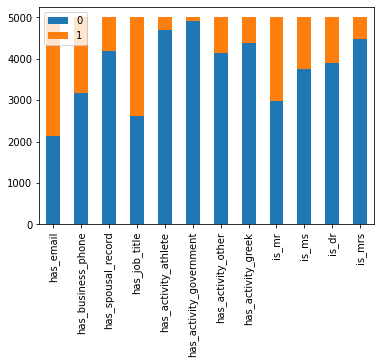

In [100]:
dre_bool_report.T.plot.bar(stacked=True)

Looking at a stacked bar chart of the all boolean columns, it is interesting to note that the incidence of <code>True</code> indicators is on average low. The only two columns that exceed 50% are has_email and has_job_title. In terms of descriptive information to have on a dataset of alumni, these are high value assets. Having a present email address allows the client organization to engage in direct mail campaigns and inform the constituent of engagement opportunities with the client organization. Having a job title would allow further slicing of the database by focusing on senior positions.

### Marital Status

In [87]:
# Exploring the category column marital_status
dre_column = 'marital_status'
print('null count',dre_df[dre_column].isnull().sum())
print('value count',dre_df[dre_column].notnull().sum())
dre_marital_report = dre_df[dre_column].value_counts()
dre_marital_report

null count 35
value count 4965


M    2160
U    1586
S     996
D     110
W     106
E       4
P       2
Z       1
Name: marital_status, dtype: int64

Marital Status has a number of issues that need to be addressed before this feature can be utilized in a statistical model. First among them is the presence of <code>null</code> values. Second, would be determining what the categories indicate. MacDonell has this to say about the provenance of the categories for this column:

> M”, for Married, quite a few are Unknown (U), and almost a thousand are Single (S). “W” and “D” probably stand for Widowed and Divorced. As for the others, your guess is as good as mine.

(2018, MacDonell, pg. 18)

With this information, a general strategy can be formed for cleaning up and imputing this column. The <code>null</code> values, along with <code>E</code>, <code>P</code>, and <code>Z</code> can be reclassified to <code>U</code>.

<AxesSubplot:>

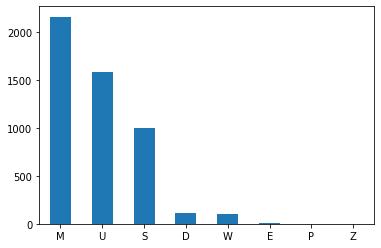

In [84]:
dre_marital_report.plot.bar(x='marital_status',y='count',rot=0)

The majority of constituents are either Married, Unknown, or Single, this indicates that the client organization only comes back into contact with their constituents after they have established themselves. If the client had a direct connection with the registrar of the school they raise funds for, it would be far more likely that the single population would be far higher. This is a good indicator for accuracy in our models as it means it is likely consituents in their database have made an initial connection with them.

### Grad Year

In [101]:
# Exploring the grad_year column
dre_column = 'grad_year'
print('null count',dre_df[dre_column].isnull().sum())
print('value count',dre_df[dre_column].notnull().sum())
print('min val', dre_df[dre_column].min())
print('max val', dre_df[dre_column].max())
dre_grad_report = dre_df[dre_column].value_counts()
dre_grad_report.sort_index(inplace=True)
dre_grad_report

null count 0
value count 5000
min val 1911
max val 2013


1911      1
1930      1
1931      1
1932      1
1934      1
       ... 
2009    135
2010    130
2011    129
2012    103
2013     12
Name: grad_year, Length: 83, dtype: int64

In [92]:
# let's categorize the date by decade to aid in visualization
dre_df['grad_decade'] = pd.cut(x=dre_df['grad_year'],
                           bins=data_dict['dummy']['grad']['bins'],
                           labels=data_dict['dummy']['grad']['labels'],
                           right=False)
dre_column = 'grad_decade'
dre_grad_decade_report = dre_df[dre_column].value_counts()
dre_grad_decade_report.sort_index(inplace=True)
dre_grad_decade_report

1900s       0
1910s       1
1920s       0
1930s      12
1940s      78
1950s     249
1960s     497
1970s     761
1980s     864
1990s    1096
2000s    1068
2010s     374
Name: grad_decade, dtype: int64

Aggregating this column by decade makes the information far easier to parse. However, I am uncertain if this will provide for a stronger or weaker model, so both versions will be tested (binned and unbinned grad_year). In terms of the distribution, ~40% of the constituents have graduated in the past 3 decades, which is typical for post secondary engagement.

<AxesSubplot:>

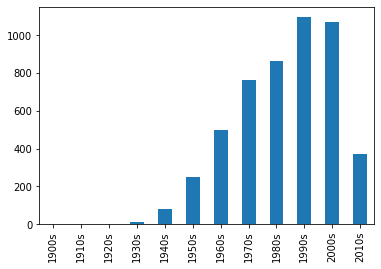

In [93]:
dre_grad_decade_report.plot.bar()

### Cumulative Donation

In [94]:
# Explore the cum_donation column
dre_column = 'cum_donation'
print('null count',dre_df[dre_column].isnull().sum())
print('value count',dre_df[dre_column].notnull().sum())
print('min val', dre_df[dre_column].min())
print('max val', dre_df[dre_column].max())

null count 0
value count 5000
min val 0.0
max val 11187224.58


In [95]:
dre_df['cum_range'] = pd.cut(x=dre_df['cum_donation'],
                             bins=data_dict['dummy']['giving']['bins'],
                             labels=data_dict['dummy']['giving']['labels'],
                             right=False)
dre_column = 'cum_range'
dre_cum_range_report = dre_df[dre_column].value_counts()
dre_cum_range_report.sort_index(inplace=True)
dre_cum_range_report

$0                2555
$1-$999.99        1843
$1K-$9.99K         518
$10K-$24.99K        46
$25K-$49.99K        14
$50K-$99.99K         7
$100K-$249.99K      10
$250K-$499.99K       4
$500K-$999.99K       0
$1M-$2.49M           2
$2.5M-$4.99M         0
$5M-$9.99M           0
$10M-$14.99M         1
Name: cum_range, dtype: int64

Similar to <code>grad_year</code> this information has been binned to aid in visual analysis in addition to providing another avenue for statistical analysis. Cumulative Donations will be modeled in their binned and unbinned states. The size of the bins increase as the magnitude of gift increases. A gift chart as demonstrated above is typical of what is used in practice in the fundraising field. It is constructed in this way to ensure the granularity seen at the lower end of giving is not deviated by larger, more infrequent gifts.

More than half of this dataset are alumni who haven't contributed - yet. From there, the curve of donations decreases steeply. The values hear are unsurprising for higher-ed.

<AxesSubplot:>

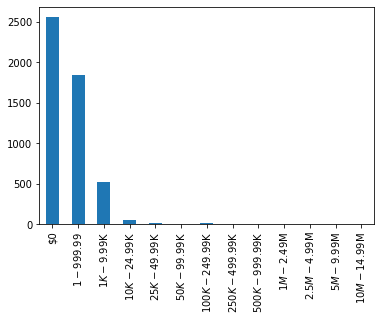

In [96]:
dre_cum_range_report.plot.bar()

## Data-Preparation

### Identifying Significant Features
The identification of significant features has been automatically implemented through the use of Chi-Square values (chi), Random Forest Importances (rfi), Recursive Feature Elimination with Cross Fold Validation (rfecv), and Forward Feature Elimination (ffe). Some of these feature selection algorithms choose features automatically - chi with features greater than 3.8 and rfecv are two such examples. In the instances where features are merely provided a weight with regard to their significance, the values were averaged on only features that exceeded that average were retained.

#### All Models with Feature Selection
22 models underwent automatic feature selection. A feature's frequency of occurrence across all models is displayed below. The most frequently occurring feature across all models, is whether or not an alumni has a spousal record associated with their record.

<AxesSubplot:>

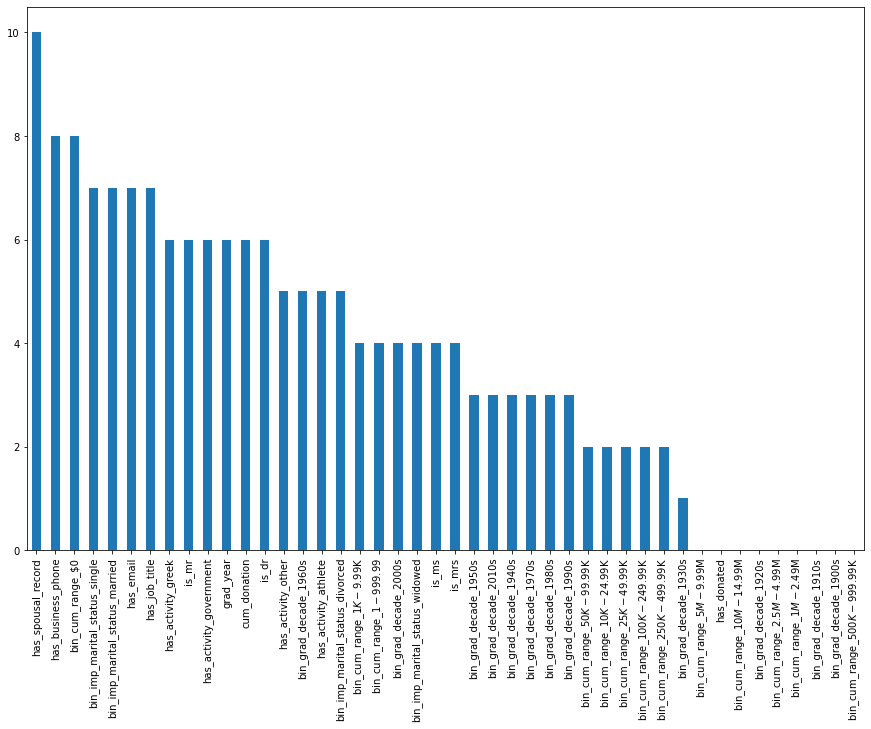

In [95]:
ff_df.T.sum().sort_values(ascending=False).plot.bar(figsize=(15,10))

#### Logistic Models with Feature Selection
When only displaying the models from logistic ancestors, the feature <code>bin_cum_range_0</code> become the most frequently selected. This is expected somewhat as the response variable <code>has_donated</code> is a derivation of <code>cum_donation</code> which the 0_bin is created from. Since the dataset is comprised of 0 donations and donations >0, this is likely the reason for its significance.

<AxesSubplot:>

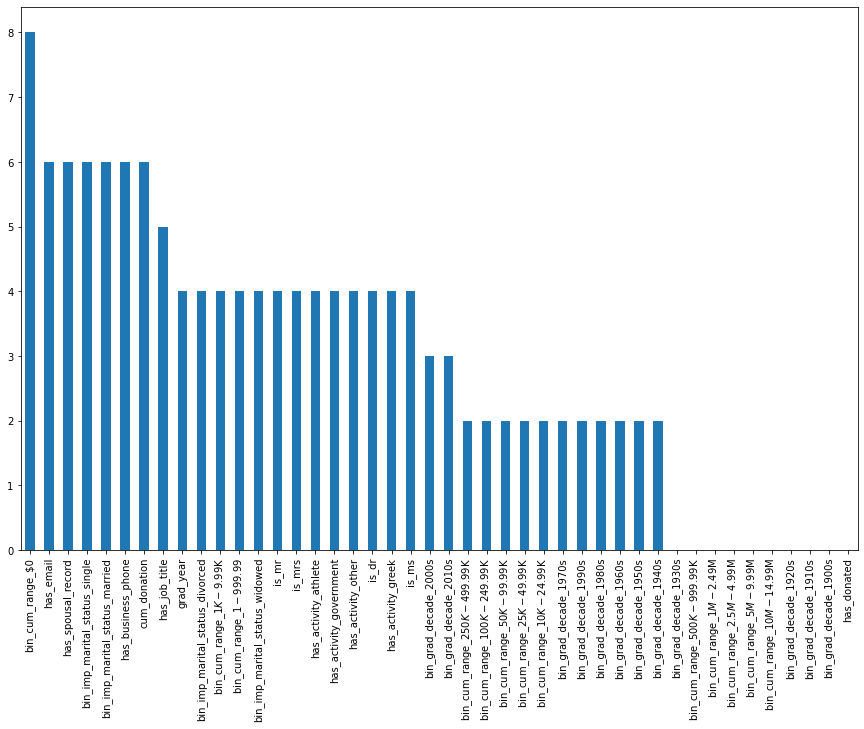

In [140]:
ff_df_log = ff_df.filter(regex='\d{5}0')
ff_df_log.T.sum().sort_values(ascending=False).plot.bar(figsize=(15,10))

#### Linear Models with Feature Selection


In [ ]:
ff_df_log = ff_df.filter(regex='\d{5}0')
ff_df_log.T.sum().sort_values(ascending=False).plot.bar(figsize=(15,10))

### Imputing and Variable Creation


## Data Modeling

### Scaling

## Model Evaluation

## Conclusion